<a href="https://www.kaggle.com/code/ardaorcun/monke-with-cnn?scriptVersionId=127683015" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd 
import numpy as np
import math
import matplotlib.pyplot as plt
import cv2
import glob 
import os
import tensorflow as tf
import itertools
import random
from random import shuffle
from tqdm import tqdm 
from tqdm.keras import TqdmCallback
from PIL import Image
from scipy import ndimage
from pathlib import Path


from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Activation, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model


%matplotlib inline 

# Creating Directions

In [2]:
#Directions
train_dir = Path('/kaggle/input/10-monkey-species/training/training')
test_dir = Path('/kaggle/input/10-monkey-species/validation/validation')

In [3]:
'''Label informs from txt file'''

cols = ['Label','Latin Name', 'Common Name','Train Images', 'Validation Images']
labels = pd.read_csv("/kaggle/input/10-monkey-species/monkey_labels.txt", names=cols, skiprows=1)
labels

,Label,Latin Name,Common Name,Train Images,Validation Images
0,n0,alouatta_palliata\t,mantled_howler,131,26
1,n1,erythrocebus_patas\t,patas_monkey,139,28
2,n2,cacajao_calvus\t,bald_uakari,137,27
3,n3,macaca_fuscata\t,japanese_macaque,152,30
4,n4,cebuella_pygmea\t,pygmy_marmoset,131,26
5,n5,cebus_capucinus\t,white_headed_capuchin,141,28
6,n6,mico_argentatus\t,silvery_marmoset,132,26
7,n7,saimiri_sciureus\t,common_squirrel_monkey,142,28
8,n8,aotus_nigriceps\t,black_headed_night_monkey,133,27
9,n9,trachypithecus_johnii,nilgiri_langur,132,26


In [4]:
labels=labels['Common Name']
labels

0     mantled_howler                
1     patas_monkey                  
2     bald_uakari                   
3     japanese_macaque              
4     pygmy_marmoset                
5     white_headed_capuchin         
6     silvery_marmoset              
7     common_squirrel_monkey        
8     black_headed_night_monkey     
9     nilgiri_langur                
Name: Common Name, dtype: object

In [5]:
def image_show(num_image,label):
    '''The input parameters are the number of images to display and the class label to select.The function uses the 'os' and 'cv2' modules to randomly select an image from the specified class, reads the image, and displays it on screen using the 'matplotlib' library.
For each displayed image, a detail window is also shown, indicating the name of the image and which folder it was selected from.
Finally, the function uses 'plt.show()' to create a single drawing object that groups all displayed images.'''

    for i in range(num_image):
        imgdir = Path('/kaggle/input/10-monkey-species/training/training/' + label)
        imgfile = random.choice(os.listdir(imgdir))
        img = cv2.imread('/kaggle/input/10-monkey-species/training/training/'+ label +'/'+ imgfile)
        plt.figure(i)
        plt.imshow(img)
        plt.title(imgfile)
    plt.show()
    

    

 pygmy_marmoset                


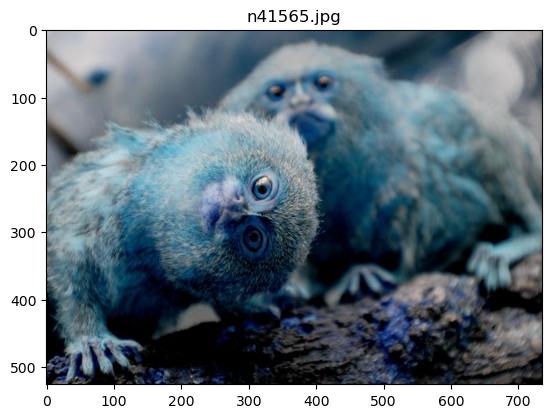

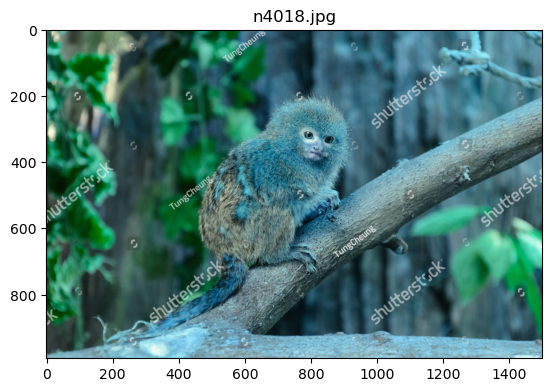

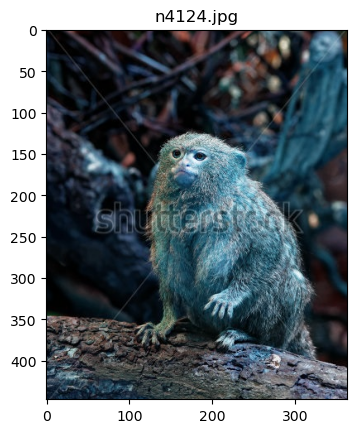

In [6]:
print(labels[4])
image_show(3,'n4')

# Constants

In [7]:
LR = 1e-3
height=150
width=150
channels=3
seed=1337
batch_size = 64
num_classes = 10
data_augmentation = True
num_predictions = 20

# Data Generators

In [8]:
# Training generator
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(height,width),
                                                    batch_size=batch_size,
                                                    seed=seed,
                                                    shuffle=True,
                                                    class_mode='categorical')

# Test generator
test_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = test_datagen.flow_from_directory(test_dir, 
                                                  target_size=(height,width), 
                                                  batch_size=batch_size,
                                                  seed=seed,
                                                  shuffle=False,
                                                  class_mode='categorical')

train_num = train_generator.samples
validation_num = validation_generator.samples 



Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


# Creating Model

In [9]:
model=Sequential()
#Layers
model.add(Conv2D(32,(3,3),input_shape=(150,150,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(32,(3,3),input_shape=(150,150,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(64, (3, 3), padding='same',activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes,activation='softmax'))

In [10]:
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 36, 36, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 34, 34, 64)        3

In [11]:
#Saving model for later and creating callbacks.
filepath=str(os.getcwd()+"/model.h5f")
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
#callback=[checkpoint, TqdmCallback(verbose=1)]

In [12]:
history=model.fit(
    train_generator,
    epochs=200,
    steps_per_epoch=train_num//batch_size,
    validation_data=train_generator,
    validation_steps=validation_num//batch_size,
    callbacks=[checkpoint,TqdmCallback(verbose=1)],
    verbose=0
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]


Epoch 1: val_acc improved from -inf to 0.17969, saving model to /kaggle/working/model.h5f

Epoch 2: val_acc did not improve from 0.17969

Epoch 3: val_acc improved from 0.17969 to 0.36328, saving model to /kaggle/working/model.h5f

Epoch 4: val_acc improved from 0.36328 to 0.44141, saving model to /kaggle/working/model.h5f

Epoch 5: val_acc improved from 0.44141 to 0.49219, saving model to /kaggle/working/model.h5f

Epoch 6: val_acc did not improve from 0.49219

Epoch 7: val_acc improved from 0.49219 to 0.50391, saving model to /kaggle/working/model.h5f

Epoch 8: val_acc did not improve from 0.50391

Epoch 9: val_acc did not improve from 0.50391

Epoch 10: val_acc did not improve from 0.50391

Epoch 11: val_acc did not improve from 0.50391

Epoch 12: val_acc improved from 0.50391 to 0.51953, saving model to /kaggle/working/model.h5f

Epoch 13: val_acc improved from 0.51953 to 0.53125, saving model to /kaggle/working/model.h5f

Epoch 14: val_acc improved from 0.53125 to 0.55469, saving

# Plotting Model Accuracy and Loss per Epoch

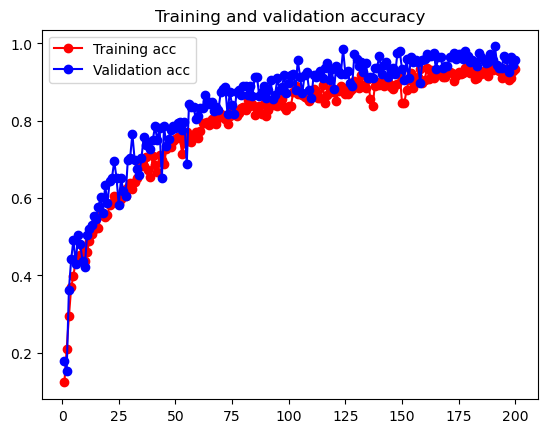

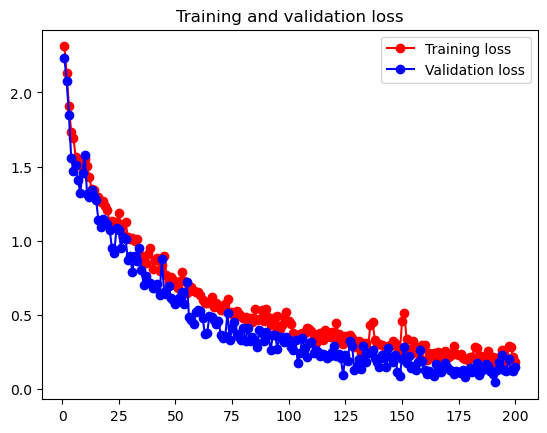

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc', marker='o')
plt.plot(epochs, val_acc, 'blue', label='Validation acc', marker='o')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss', marker='o')
plt.plot(epochs, val_loss, 'blue', label='Validation loss', marker='o')

plt.legend()

plt.show()

In [14]:
def plot_confusion_matrix(cm, target_names,title='Confusion matrix',cmap=None,normalize=False):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float32') / cm.sum(axis=1)
        cm = np.round(cm,2)
        

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel("Predicted label\naccuracy={:0.4f}\n misclass={:0.4f}".format(accuracy, misclass))
    plt.show()


5/5 [==============================] - 12s 2s/step


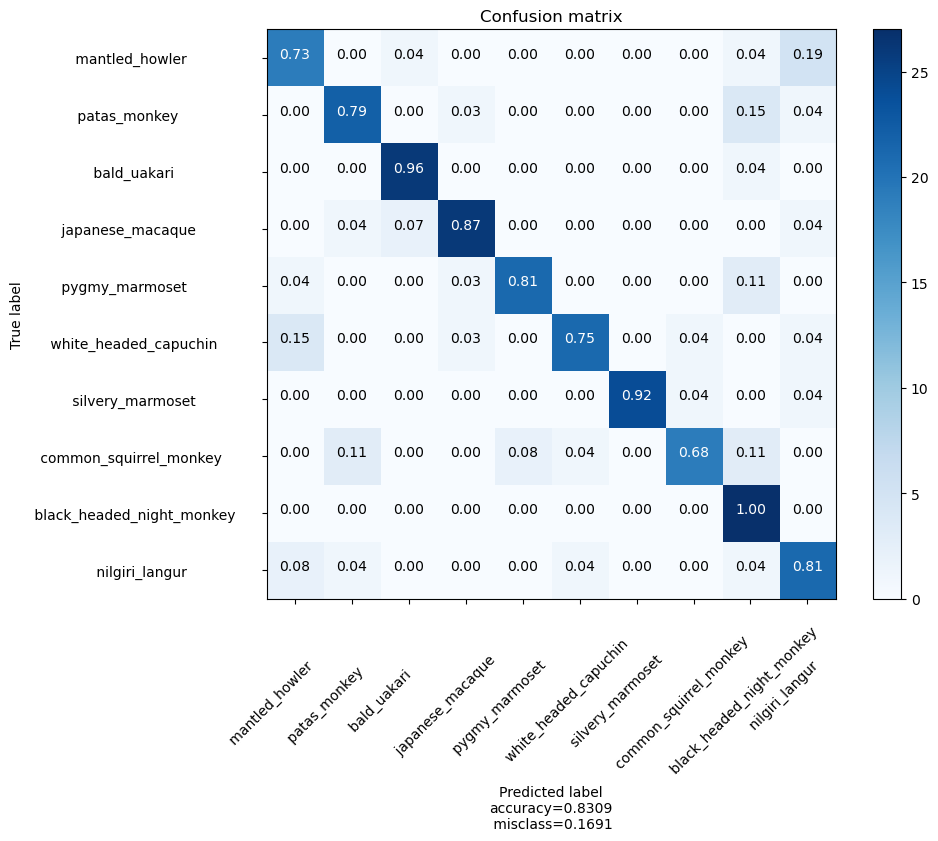

In [15]:
model_trained = load_model(filepath)
# Predict the values from the validation dataset
Y_pred = model_trained.predict(validation_generator, validation_num // batch_size+1)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1)
# Convert validation observations to one hot vectors
#Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true = validation_generator.classes,y_pred = Y_pred_classes)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, normalize=True, target_names=labels)


In [16]:
print(metrics.classification_report(validation_generator.classes, Y_pred_classes,target_names=labels))


                                 precision    recall  f1-score   support

 mantled_howler                       0.73      0.73      0.73        26
 patas_monkey                         0.81      0.79      0.80        28
 bald_uakari                          0.90      0.96      0.93        27
 japanese_macaque                     0.90      0.87      0.88        30
 pygmy_marmoset                       0.91      0.81      0.86        26
 white_headed_capuchin                0.91      0.75      0.82        28
 silvery_marmoset                     1.00      0.92      0.96        26
 common_squirrel_monkey               0.90      0.68      0.78        28
 black_headed_night_monkey            0.68      1.00      0.81        27
 nilgiri_langur                       0.70      0.81      0.75        26

                       accuracy                           0.83       272
                      macro avg       0.84      0.83      0.83       272
                   weighted avg       0.85      0

In [17]:
!pip install ann_visualizer
!pip3 install graphviz


  Preparing metadata (setup.py) ... - done
  Created wheel for ann_visualizer: filename=ann_visualizer-2.5-py3-none-any.whl size=4168 sha256=08bd193c1ddb6b9cf00df5c0a0e804f3bb131189a6c826826c2fc0be2f52eec3
  Stored in directory: /root/.cache/pip/wheels/9d/fb/fa/cc002927ad0327942fc1eba45ce3bedd1e128c6d5c21f1d851
Successfully built ann_visualizer


In [18]:
#from ann_visualizer.visualize import ann_viz

#ann_viz(model, view = True, filename = "ann.gv")